Original Graph Memory Code:

https://arxiv.org/abs/2407.04363

https://github.com/AIRI-Institute/AriGraph/tree/main


# Memory

## Prompts

In [7]:
# prompts.py

prompt_refining_items = """You will be provided with list of existing triplets and list of new triplets. Triplets are in the following format: "subject, relation, object".
The triplets denote facts about the environment where the player moves. The player takes actions and the environment changes, so some triplets from the list of existing triplets can be replaced with one of the new triplets. For example, the player took the item from the locker and the existing triplet "item, is in, locker" should be replaced with the new triplet "item, is in, inventory".

Sometimes there are no triplets to replace:
Example of existing triplets: "Golden locker, state, open"; "Room K, is west of, Room I"; "Room K, has exit, east".
Example of new triplets: "Room T, is north of, Room N"; "Room T, has exit, south".
Example of replacing: []. Nothisg to replace here

Sometimes several triplets can be replaced with one:
Example of existing triplets: "kitchen, contains, broom"; "broom, is on, floor".
Example of new triplets: "broom, is in, inventory".
Example of replacing: [["kitchen, contains, broom" -> "broom, is in, inventory"], ["broom, is on, floor" -> "broom, is in, inventory"]]. Because broom changed location from the floor in the kitchen to players inventory.

Ensure that triplets are only replaced if they contain redundant or conflicting information about the same aspect of an entity. Triplets should not be replaced if they provide distinct or complementary information about entities compared to the new triplets. Specifically, consider the relationships, properties, or contexts described by each triplet and verify that they align before replacement. If there is uncertainty about whether a triplet should be replaced, prioritize retaining the existing triplet over replacing it. When comparing existing and new triplets, if they refer to different aspects or attributes of entities, do not replace them. Replacements should only occur when there is semantic duplication between an existing triplet and a new triplet.
Example of existing triplets: "apple, to be, cooked", 'knife, used for, cutting', 'apple, has been, sliced'
Example of new triplets: "apple, is on, table", 'kitchen, contsins, knife', 'apple, has beed, grilled'.
Example of replacing: []. Nothing to replace here. These triplets describe different properties of items, so they should not be replaced.

Another example of when not to replase existung triplets:
Example of existing triplets: "brush, used for, painting".
Example of new triplets: "brush, is in, art class".
Example of replacing: []. Nothing to replace here. These triplets describe different properties of brush, so they should not be replaced.

I repeat, do not replace triplets, if they carry differend type of information about entities!!! It is better to leave a tripplet, than to replace the one that has important information. Do not state that triplet needs to be replaced if you are not sure!!!
If you find triplet in Existing triplets which semantically duplicate some triplet in New triplets, replace such triplet from Existing triplets. However do not replace triplets if they refer to different things.
####

Generate only replacing, no descriptions are needed.
Existing triplets: {ex_triplets}.
New triplets: {new_triplets}.
####
Warning! Replacing must be generated strictly in following format: [[outdated_triplet_1 -> actual_triplet_1], [outdated_triplet_2 -> actual_triplet_2], ...], you MUST NOT include any descriptions in answer.
Replacing: """

prompt_extraction_current = '''Objective: The main goal is to meticulously gather information from game observations and organize this data into a clear, structured knowledge graph.

Guidelines for Building the Knowledge Graph:

Creating Nodes and Triplets: Nodes should depict entities or concepts, similar to Wikipedia nodes. Use a structured triplet format to capture data, as follows: "subject, relation, object". For example, from "Albert Einstein, born in Germany, is known for developing the theory of relativity," extract "Albert Einstein, country of birth, Germany; Albert Einstein, developed, Theory of Relativity."
Remember that you should break complex triplets like "John, position, engineer in Google" into simple triplets like "John, position, engineer", "John, work at, Google".
Length of your triplet should not be more than 7 words. You should extract only concrete knowledges, any assumptions must be described as hypothesis.
For example, from phrase "John have scored many points and potentially will be winner" you should extract "John, scored many, points; John, could be, winner" and should not extract "John, will be, winner".
Remember that object and subject must be an atomary units while relation can be more complex and long.
If observation states that you take item, the triplet shoud be: 'item, is in, inventory' and nothing else.

Do not miss important information. If observation is 'book involves story about knight, who needs to kill a dragon', triplets should be 'book, involves, knight', 'knight, needs to kill, dragon'. If observation involves some type of notes, do not forget to include triplets about entities this note includes.
There could be connections between distinct parts of observations. For example if there is information in the beginning of the observation that you are in location, and in the end it states that there is an exit to the east, you should extract triplet: 'location, has exit, east'.
Several triplets can be extracted, that contain information about the same node. For example 'kitchen, contains, apple', 'kitchen, contains, table', 'apple, is on, table'. Do not miss this type of connections.
Other examples of triplets: 'room z, contains, black locker'; 'room x, has exit, east', 'apple, is on, table', 'key, is in, locker', 'apple, to be, grilled', 'potato, to be, sliced', 'stove, used for, frying', 'recipe, requires, green apple', 'recipe, requires, potato'.
Do not include triplets that state the current location of an agent like 'you, are in, location'.
Do not use 'none' as one of the entities.
If there is information that you read something, do not forget to incluse triplets that state that entitie that you read contains information that you extract.

Example of triplets you have extracted before: {example}

Observation: {observation}

Remember that triplets must be extracted in format: "subject_1, relation_1, object_1; subject_2, relation_2, object_2; ..."

Extracted triplets: '''



## Retriever

In [8]:
import os
import re
import ast
import json
import torch
import numpy as np
from copy import deepcopy
from inspect import signature
import matplotlib.pyplot as plt

#############################
# for paranet_graph.py

def clear_triplet(triplet):
    # "I" -> inventory, "P" -> user, "N" -> npc
    if triplet[0] == "I":
        triplet = ("inventory", triplet[1], triplet[2])
    if triplet[1] == "I":
        triplet = (triplet[0], "inventory", triplet[2])
    if triplet[0] == "P":
        triplet = ("user", triplet[1], triplet[2])
    if triplet[1] == "P":
        triplet = (triplet[0], "user", triplet[2])
    if triplet[0] == "N":
        triplet = ("npc", triplet[1], triplet[2])
    if triplet[1] == "N":
        triplet = (triplet[0], "npc", triplet[2])
    return [triplet[0].lower().strip('''"'. `;:'''),
            triplet[1].lower().strip('''"'. `;:'''),
            {"label": triplet[2]["label"].lower().strip('''"'. `;:''')}]

def sort_scores(data):
    """
    data['idx']와 data['scores']가 단일 값일 경우에도 리스트 형태로 다룰 수 있도록 보정합니다.
    각 쿼리에 대해 인덱스와 점수를 인덱스 기준 오름차순으로 정렬합니다.
    """
    idx_data = data['idx']
    score_data = data['scores']

    # 단일 값이면 리스트로 감싸기
    if not isinstance(idx_data, list):
        idx_data = [idx_data]
    if not isinstance(score_data, list):
        score_data = [score_data]
    # 만약 내부가 단일 int/float라면 한 번 더 리스트로 감싸기
    if idx_data and not isinstance(idx_data[0], list):
        idx_data = [idx_data]
    if score_data and not isinstance(score_data[0], list):
        score_data = [score_data]

    sorted_idx_all = []
    sorted_scores_all = []
    for idx_list, score_list in zip(idx_data, score_data):
        paired = list(zip(idx_list, score_list))
        paired_sorted = sorted(paired, key=lambda x: x[0])
        if paired_sorted:
            idx_sorted, score_sorted = zip(*paired_sorted)
        else:
            idx_sorted, score_sorted = [], []
        sorted_idx_all.append(list(idx_sorted))
        sorted_scores_all.append(list(score_sorted))
    return {'idx': sorted_idx_all, 'scores': sorted_scores_all}


#############################
# for contriever_graph.py

def process_triplets(raw_triplets):
    raw_triplets = raw_triplets.split(";")
    triplets = []
    for triplet in raw_triplets:
        if len(triplet.split(",")) != 3:
            continue
        if triplet[0] in "123456789":
            triplet = triplet[2:]
        subj, relation, obj = triplet.split(",")
        subj = subj.split(":")[-1].strip(''' '\n"''')
        relation = relation.strip(''' '\n"''')
        obj = obj.strip(''' '\n"''')
        if len(subj) == 0 or len(relation) == 0 or len(obj) == 0:
            continue
        triplets.append([subj, obj, {"label": relation}])
    return triplets


def parse_triplets_removing(text):
    text = text.split("[[")[-1] if "[[" in text else text.split("[\n[")[-1]
    text = text.replace("[", "")
    text = text.strip("]")
    pairs = text.split("],")
    parsed_triplets = []
    for pair in pairs:
        splitted_pair = pair.split("->")
        if len(splitted_pair) != 2:
            continue
        first_triplet = splitted_pair[0].split(",")
        if len(first_triplet) != 3:
            continue
        subj = first_triplet[0].strip(''' '"\n''')
        rel = first_triplet[1].strip(''' '"\n''')
        obj = first_triplet[2].strip(''' '"\n''')
        parsed_triplets.append([subj, obj, {"label": rel}])
    return parsed_triplets


def find_top_episodic_emb(A, B, obs_plan_embedding, retriever):
    results = {}
    if not B:
        return results
    # B 딕셔너리의 각 value[1]을 스택하여 (N, embed_dim) 형태의 2차원 텐서를 만듭니다.
    key_embeddings = torch.stack([value[1] for value in B.values()])

    # obs_plan_embedding이 1차원인 경우 2차원으로 변경
    if obs_plan_embedding.ndim == 1:
        obs_plan_embedding = obs_plan_embedding.unsqueeze(0)

    # Retriever를 이용하여 similarity 계산 (topk로 전체 결과 반환)
    similarity_results = retriever.search_in_embeds(
        key_embeds=key_embeddings,
        query_embeds=obs_plan_embedding,
        topk=len(B),  # 모든 항목에 대한 점수 반환
        return_scores=True
    )

    similarity_results = sort_scores(similarity_results)

    # 전체 A 요소의 개수 (나중에 match score 정규화를 위해 사용)
    total_elements = len(A)

    # similarity_results['scores']는 리스트의 리스트 형태로 되어 있음
    if similarity_results['scores']:
        similarity_scores = similarity_results['scores'][0]
    else:
        similarity_scores = [0] * len(B)

    # similarity_scores는 이미 float 값이므로 .item() 호출 없이 정규화 수행
    max_similarity_score = max(similarity_scores, default=0)
    similarity_scores = [score / max_similarity_score if max_similarity_score else 0 for score in similarity_scores]

    # A의 요소와 B의 각 value_list 간의 매칭 횟수를 계산
    match_counts = [sum(1 for element in A if element in value_list) for _, (value_list, _) in B.items()]

    match_counts_relative = []
    for i, values in enumerate(B.values()):
        # values[0]가 리스트라고 가정
        match_counts_relative.append((match_counts[i] / (len(values[0]) + 1e-9)) * np.log((len(values[0]) + 1e-9)))

    max_match_count = max(match_counts_relative, default=0)
    normalized_match_scores = [count / max_match_count if max_match_count else 0 for count in match_counts_relative]

    # 결과 딕셔너리에 정규화된 match score와 similarity score를 저장
    for idx, (key, _) in enumerate(B.items()):
        results[key] = [normalized_match_scores[idx], similarity_scores[idx]]

    return results



def top_k_obs(input_dict, k):
    # 각 키의 리스트 값의 합계를 계산
    sum_dict = {key: sum(values) for key, values in input_dict.items()}
    # 합계를 기준으로 내림차순 정렬 후 상위 k개 키 반환
    sorted_keys = sorted(sum_dict, key=sum_dict.get, reverse=True)
    return sorted_keys[:k]


In [9]:
from sentence_transformers import SentenceTransformer
import torch
from collections import OrderedDict

# 전역 캐시 (LRU 방식)
embedding_cache = OrderedDict()
CACHE_SIZE = 100  # 캐싱할 최대 임베딩 개수


class Retriever:
    """
    Sentence-BERT를 기반으로 문장 임베딩을 생성하는 클래스.
    또한 key와 query 임베딩 간의 유사도 계산을 통해 상위 결과를 반환하는 search_in_embeds 메서드를 제공합니다.
    """
    def __init__(self, device='cpu', model_name='sentence-transformers/all-MiniLM-L6-v2'):
        self.device = device
        self.embedder = SentenceTransformer(model_name, device=device)

    def embed(self, texts):
        """
        주어진 문자열 리스트를 임베딩 텐서로 변환합니다.
        :param texts: list[str]
        :return: torch.Tensor, shape: (num_texts, embed_dim)
        """
        embeddings = self.embedder.encode(texts, convert_to_tensor=True, device=self.device)
        return embeddings

    @torch.no_grad()
    def search_in_embeds(self, key_embeds, query_embeds, topk: int = None, similarity_threshold: float = None,
                         return_embeds: bool = False, return_scores: bool = False):

        """
        key_embeds와 query_embeds 간의 유사도를 계산하여,
        topk 개의 가장 유사한 결과(또는 similarity_threshold 이상의 결과)를 반환합니다.
        """
        if int(topk is None) + int(similarity_threshold is None) != 1:
            raise ValueError("You should specify either topk or similarity_threshold but not both!")

        # 마지막 두 차원을 전치하도록 수정
        scores = query_embeds @ key_embeds.transpose(-1, -2)  # shape: (M, N)
        batch_request = len(query_embeds.shape) > 1
        if not batch_request:
            scores = scores.reshape(1, -1)
        num_q = scores.shape[0]

        if topk is not None:
            sorted_idx = scores.argsort(dim=-1, descending=True)
            selected_idx = sorted_idx[:, :topk]
            selected_idx = selected_idx.tolist()
        else:
            selected_idx = [[] for _ in range(num_q)]
            nonzero_indices = (scores >= similarity_threshold).nonzero(as_tuple=False)
            for item in nonzero_indices:
                q_id, k_id = item[0].item(), item[1].item()
                selected_idx[q_id].append(k_id)

        result = {'idx': selected_idx}
        if return_embeds:
            result['embeds'] = [
                [key_embeds[k_id] for k_id in selected_idx[q_id]]
                for q_id in range(num_q)
            ]
        if return_scores:
            result['scores'] = [
                [scores[q_id, k_id].item() for k_id in selected_idx[q_id]]
                for q_id in range(num_q)
            ]
        if not batch_request:
            result = {k: v[0] for k, v in result.items()}
        return result





def get_cached_embeddings(texts, retriever):
    """
    주어진 문자열 리스트에 대해 캐시된 임베딩이 있으면 사용하고,
    없는 경우 Retriever.embed()를 통해 계산한 후 캐싱합니다.
    :param texts: 임베딩을 구할 문자열 리스트
    :param retriever: Retriever 인스턴스
    :return: (num_texts, embed_dim) 크기의 텐서
    """
    results = [None] * len(texts)
    texts_to_compute = []
    indices_to_compute = []

    for i, text in enumerate(texts):
        if text in embedding_cache:
            embedding_cache.move_to_end(text)
            results[i] = embedding_cache[text]
        else:
            texts_to_compute.append(text)
            indices_to_compute.append(i)

    if texts_to_compute:
        computed = retriever.embed(texts_to_compute)
        for idx, text, emb in zip(indices_to_compute, texts_to_compute, computed):
            results[idx] = emb
            embedding_cache[text] = emb
            if len(embedding_cache) > CACHE_SIZE:
                embedding_cache.popitem(last=False)

    return torch.stack(results)


"""
@torch.no_grad()
def graph_retr_search(start_query, triplets, retriever, max_depth: int = 2,
                      topk: int = 3, post_retrieve_threshold: float = 0.7,
                      verbose: int = 2):
    # triplets 임베딩 (2차원 텐서: (N, embed_dim))
    key_embeds = get_cached_embeddings(triplets, retriever)

    current_level = [start_query]
    depth = {start_query: 0}
    result = []
    visited = set([start_query])

    while current_level:
        query_embeds = get_cached_embeddings(current_level, retriever)
        # query_embeds가 1차원일 경우 2차원으로 변환
        if query_embeds.ndim == 1:
            query_embeds = query_embeds.unsqueeze(0)

        # 마지막 두 차원만 전치하여 (M, N) 형태의 유사도 행렬 계산
        scores = query_embeds @ key_embeds.transpose(-1, -2)
        effective_topk = min(topk, scores.shape[1])
        topk_values, topk_indices = scores.topk(effective_topk, dim=1)

        next_level = []
        for i, query in enumerate(current_level):
            for score, idx in zip(topk_values[i].tolist(), topk_indices[i].tolist()):
                if score < post_retrieve_threshold:
                    continue
                triplet = triplets[idx]
                parts = [part.strip() for part in triplet.split(",")]
                if len(parts) < 3:
                    continue
                v1, relation, v2 = parts[:3]
                for v in [v1, v2]:
                    if v not in visited and depth[query] < max_depth:
                        visited.add(v)
                        next_level.append(v)
                        depth[v] = depth[query] + 1
                if triplet not in result:
                    result.append(triplet)
                if verbose >= 2:
                    print(f"[Depth {depth[query]}] Query: '{query}' -> Triplet: '{triplet}' (Score: {score:.3f})")
        current_level = next_level
    return result
"""

@torch.no_grad()
def graph_retr_search(start_triplet, triplets, retriever, max_depth: int = 2,
                      topk: int = 3, post_retrieve_threshold: float = 0.7,
                      verbose: int = 2):
    """
    시작 쿼리(triplet)를 기반으로 주어진 triplets에서 BFS 방식으로 관련 결과를 탐색합니다.
    쿼리와 후보 모두 "v1, relation, v2" 형식의 문자열이며, 임베딩을 통해 전체 문맥을 비교합니다.

    :param start_triplet: 시작 트리플릿 문자열 (예: "user, is in, operations conference barracks")
    :param triplets: 후보 트리플릿 문자열들의 리스트
    :param retriever: Retriever 인스턴스
    :param max_depth: 최대 탐색 깊이 (현재 트리플릿에서 확장할 수 있는 단계)
    :param topk: 각 쿼리마다 고려할 상위 k개 후보
    :param post_retrieve_threshold: 유사도 임계치 (이 값 미만인 후보는 무시)
    :param verbose: 디버그 출력을 위한 출력 레벨 (2 이상이면 상세 출력)
    :return: 조건에 맞는 트리플릿 문자열들의 리스트
    """
    # 후보 트리플릿 임베딩 (2차원 텐서: (N, embed_dim))
    key_embeds = get_cached_embeddings(triplets, retriever)

    current_level = [start_triplet]  # 검색 쿼리(트리플릿) 리스트
    depth = {start_triplet: 0}         # 각 트리플릿의 탐색 깊이 기록
    result = set()                   # 최종 검색된 트리플릿 집합
    visited = set([start_triplet])   # 중복 검색 방지를 위한 방문 집합

    while current_level:
        query_embeds = get_cached_embeddings(current_level, retriever)
        if query_embeds.ndim == 1:
            query_embeds = query_embeds.unsqueeze(0)
        # 안전하게 마지막 두 차원을 전치하여 유사도 행렬 계산
        scores = query_embeds @ key_embeds.transpose(-1, -2)
        effective_topk = min(topk, scores.shape[1])
        topk_values, topk_indices = scores.topk(effective_topk, dim=1)

        next_level = []
        for i, query in enumerate(current_level):
            current_depth = depth[query]
            for score, idx in zip(topk_values[i].tolist(), topk_indices[i].tolist()):
                if score < post_retrieve_threshold:
                    continue
                candidate_triplet = triplets[idx]
                if candidate_triplet in visited:
                    continue
                # 후보 트리플릿을 결과에 추가하고, 아직 깊이 제한 안에 있다면 확장 대상으로 포함
                result.add(candidate_triplet)
                if current_depth < max_depth:
                    next_level.append(candidate_triplet)
                    depth[candidate_triplet] = current_depth + 1
                    visited.add(candidate_triplet)
                if verbose >= 2:
                    print(f"[Depth {current_depth}] Query: '{query}' -> Triplet: '{candidate_triplet}' (Score: {score:.3f})")
        current_level = next_level
    return list(result)




# Example usage:
if __name__ == "__main__":
    # Retriever 인스턴스 초기화 (예: GPU 사용 시 device='cuda')
    my_retriever = Retriever(device='cpu')

    # 예시 triplets (각 문자열은 "v1, relation, v2" 형식)
    triplets = [
        "apple, is a, fruit",
        "fruit, can be, eaten",
        "banana, is a, fruit",
        "apple, is related to, banana",
        "orange, is a, fruit",
    ]

    start_query = "apple"

    results = graph_retr_search(start_query, triplets, my_retriever,
                                max_depth=3, topk=3, post_retrieve_threshold=0.55, verbose=1)

    print("\nGraph Search Results:")
    for r in results:
        print(r)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]


Graph Search Results:
banana, is a, fruit
orange, is a, fruit
apple, is a, fruit
apple, is related to, banana


## AriGraph

In [10]:
import re
from time import time
from copy import deepcopy
import json
import requests
from time import time, sleep
from openai import OpenAI

#from utils.utils import clear_triplet, check_conn, find_relation

class ContrieverGraph:
    def __init__(self, model, system_prompt, api_key, device="cpu", debug=False):
        self.triplets = []
        self.items = []  # items 목록 초기화
        self.model, self.system_prompt = model, system_prompt
        self.debug = debug  # 디버그 모드 플래그
        self.client = OpenAI(
            api_key=api_key,
        )
        self.total_amount=0

        self.retriever = Retriever(device)
        self.triplets_emb, self.items_emb = {}, {}
        self.obs_episodic, self.obs_episodic_list, self.top_episodic_dict_list = {}, [], []

    def clear(self):
        self.triplets = []
        self.total_amount = 0
        self.triplets_emb, self.items_emb = {}, {}
        self.obs_episodic, self.obs_episodic_list, self.top_episodic_dict_list = {}, [], []

    def generate(self, prompt, jsn=False, t=0.7):
        if jsn:
            chat_completion = self.client.chat.completions.create(
                messages=[
                    {
                        "role": "system",
                        "content": self.system_prompt,
                    },
                    {
                        "role": "user",
                        "content": prompt,
                    }
                ],
                model=self.model,
                response_format={"type": "json_object"},
                temperature=t
            )
        else:
            chat_completion = self.client.chat.completions.create(
                messages=[
                    {
                        "role": "system",
                        "content": self.system_prompt,
                    },
                    {
                        "role": "user",
                        "content": prompt,
                    }
                ],
                model=self.model,
                temperature=t
            )
        response = chat_completion.choices[0].message.content
        prompt_tokens = chat_completion.usage.prompt_tokens
        completion_tokens = chat_completion.usage.completion_tokens

        cost = completion_tokens * 3 / 100000 + prompt_tokens * 1 / 100000
        self.total_amount += cost
        return response, cost

    # For triplet without embeddings
    def str(self, triplet):
        return triplet[0] + ", " + triplet[2]["label"] + ", " + triplet[1]


    # Associations by set of items. Step is a parameter for BFS
    def get_associated_triplets(self, items, steps=2):
        items = deepcopy([string.lower() for string in items])
        associated_triplets = []

        for i in range(steps):
            now = set()
            for triplet in self.triplets:
                for item in items:
                    if (item == triplet[0] or item == triplet[1]) and self.str(triplet) not in associated_triplets:
                        associated_triplets.append(self.str(triplet))
                        if item == triplet[0]:
                            now.add(triplet[1])
                        if item == triplet[1]:
                            now.add(triplet[0])
                        break

            if "itself" in now:
                now.remove("itself")
            items = now
        return associated_triplets

    # Exclude facts from 'triplets' which already in graph
    def exclude(self, triplets):
        new_triplets = []
        for triplet in triplets:
            triplet = clear_triplet(triplet)
            if triplet not in self.triplets:
                new_triplets.append(self.str(triplet))
        return new_triplets

    def update(self, observation, plan, prev_subgraph, locations, action, items1, log, topk_episodic, recent_n=5):
        overall_start = time()
        if self.debug:
            print("=== DEBUG: 시작 update ===")

        # 1. 트리플릿 추출 및 처리
        t0 = time()
        example = [re.sub(r"Step \d+: ", "", triplet) for triplet in prev_subgraph]
        prompt = prompt_extraction_current.format(observation=observation, example=example)
        if self.debug:
            print(f"[Extraction] 프롬프트 생성 시간: {time() - t0:.4f} sec")

        t1 = time()
        response, _ = self.generate(prompt, t=0.001)
        if self.debug:
            print(f"[Extraction] generate 호출 시간: {time() - t1:.4f} sec")

        t2 = time()
        new_triplets_raw = process_triplets(response)
        if self.debug:
            print(f"[Extraction] 트리플릿 파싱 시간: {time() - t2:.4f} sec")

        t3 = time()
        new_triplets = self.exclude(new_triplets_raw)
        new_triplets_str = self.convert(new_triplets_raw)
        if self.debug:
            print(f"[Extraction] 제외 및 변환 시간: {time() - t3:.4f} sec")

        log("New triplets: " + str(new_triplets))
        t4 = time()
        items_ = {triplet[0] for triplet in new_triplets_raw} | {triplet[1] for triplet in new_triplets_raw}
        associated_subgraph = self.get_associated_triplets(items_, steps=1)
        words_to_exclude = ['west', 'east', 'south', 'north', 'associated with', 'used for', 'to be']
        associated_subgraph = [item for item in associated_subgraph if not any(word in item for word in words_to_exclude)]
        if self.debug:
            print(f"[Extraction] 연관 서브그래프 계산 시간: {time() - t4:.4f} sec")

        # 2. 아이템 세부 정제 및 구 outdated 트리플릿 삭제
        t5 = time()
        prompt = prompt_refining_items.format(ex_triplets=associated_subgraph, new_triplets=new_triplets)
        response, _ = self.generate(prompt, t=0.001)
        predicted_outdated = parse_triplets_removing(response)
        self.delete_triplets(predicted_outdated, locations)
        if self.debug:
            print(f"[Refinement] 정제 및 삭제 시간: {time() - t5:.4f} sec")
        log("Outdated triplets: " + response)
        log("NUMBER OF REPLACEMENTS: " + str(len(predicted_outdated)))

        # 4. 새로운 트리플릿을 그래프에 추가
        t7 = time()
        self.add_triplets(new_triplets_raw)
        if self.debug:
            print(f"[Add Triplets] 추가 시간: {time() - t7:.4f} sec")

        # 5. 최근 n개의 트리플릿 기반 연관 서브그래프 재계산
        t8 = time()
        triplets = self.triplets_to_str(self.triplets)  # 전체 그래프의 후보 트리플릿들
        associated_subgraph_new = set()
        # 최근에 추가된 n개의 트리플릿을 가져옵니다.
        recent_triplets = self.triplets[-recent_n:]
        recent_triplets_str = self.triplets_to_str(recent_triplets)
        for trip in recent_triplets_str:
            # 각 트리플릿을 시작 쿼리로 하여 BFS 기반 검색을 수행합니다.
            results = graph_retr_search(
                trip, triplets, self.retriever,
                max_depth=3,    # 원하는 최대 깊이로 설정
                topk=6,
                post_retrieve_threshold=0.65,
                verbose=2
            )
            associated_subgraph_new.update(results)
        # 이미 최근에 추가된 트리플릿은 제외합니다.
        associated_subgraph_new = [element for element in associated_subgraph_new if element not in recent_triplets_str]
        if self.debug:
            print(f"[Retrieval] 최근 {recent_n}개 triplet 기반 연관 서브그래프 계산 시간: {time() - t8:.4f} sec")

        # 6. episodic memory 계산
        t9 = time()
        obs_plan_embeddings = self.retriever.embed(plan)
        top_episodic_dict = find_top_episodic_emb(prev_subgraph, deepcopy(self.obs_episodic), obs_plan_embeddings, self.retriever)
        top_episodic = top_k_obs(top_episodic_dict, k=topk_episodic)
        if self.debug:
            print(f"[Episodic] top episodic 계산 시간: {time() - t9:.4f} sec")

        # 7. plan의 context를 episodic memory에 저장 (중복 추가 방지)
        t10 = time()
        try:
            plan_dict = json.loads(plan)
            context_info = plan_dict.get("context_info", "")
        except Exception as e:
            context_info = ""
        if context_info and context_info not in self.obs_episodic:
            context_embedding = self.retriever.embed(context_info)
            context_value = [new_triplets_str, context_embedding]
            self.obs_episodic[context_info] = context_value
        if self.debug:
            print(f"[Final] plan context 임베딩 및 업데이트 시간: {time() - t10:.4f} sec")

        overall_time = time() - overall_start
        if self.debug:
            print(f"=== DEBUG: 전체 update 소요 시간: {overall_time:.4f} sec ===")
        return associated_subgraph_new, top_episodic


    def triplets_to_str(self, triplets):
        return [self.str(triplet) for triplet in triplets]

    def convert(self, triplets):
        new_triplets = []
        for triplet in triplets:
            triplet = clear_triplet(triplet)
            new_triplets.append(self.str(triplet))
        return new_triplets

    def get_embedding_local(self, text):
        return self.retriever.embed([text])[0].cpu().detach().numpy()

    def add_triplets(self, triplets):
        for triplet in triplets:
            if triplet[2]["label"] == "free":
                continue
            triplet = clear_triplet(triplet)
            if triplet not in self.triplets:
                self.triplets.append(triplet)
                self.triplets_emb[self.str(triplet)] = self.get_embedding_local(self.str(triplet))
                if triplet[0] not in self.items_emb:
                    self.items_emb[triplet[0]] = self.get_embedding_local(triplet[0])
                if triplet[1] not in self.items_emb:
                    self.items_emb[triplet[1]] = self.get_embedding_local(triplet[1])

    def delete_triplets(self, triplets, locations):
        for triplet in triplets:
            if triplet[0] in locations and triplet[1] in locations:
                continue
            if triplet in self.triplets:
                self.triplets.remove(triplet)
                self.triplets_emb.pop(self.str(triplet), None)


## Graph Plot

In [11]:
!pip install adjustText
# Colab에서 한글 폰트 설치 (NanumGothic)
!apt-get update -qq
!apt-get install -qq fonts-nanum
!fc-cache -fv

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Selecting previously unselected package fonts-nanum.
(Reading database ... 126213 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no

In [12]:

import os
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import networkx as nx
from adjustText import adjust_text
import textwrap

# Nanum 폰트가 설치된 디렉토리 내의 .ttf 파일 목록 가져오기
nanum_font_paths = [os.path.join(root, file)
                    for root, dirs, files in os.walk('/usr/share/fonts/truetype/nanum')
                    for file in files if file.endswith('.ttf')]

# 설치된 Nanum 폰트가 있는지 확인하고, 첫 번째 폰트를 사용하도록 설정
if nanum_font_paths:
    font_path = nanum_font_paths[0]
    fm.fontManager.addfont(font_path)
    font_name = fm.FontProperties(fname=font_path).get_name()
    plt.rcParams['font.family'] = font_name
    print(f"Using font: {font_name}")
else:
    print("Nanum 폰트를 찾을 수 없습니다. 다른 한글 폰트를 사용하세요.")

plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

def plot_contriever_graph(graph):
    """

    """
    # Directed NetworkX 그래프 생성
    G = nx.DiGraph()
    for triplet in graph.triplets:
        subject, obj, attrs = triplet
        relation = attrs.get("label", "")
        G.add_node(subject)
        G.add_node(obj)
        G.add_edge(subject, obj, relation=relation)

    # spring_layout을 사용하여 노드들이 균일하게 분포되도록 설정 (k값과 반복 횟수를 조정)
    pos = nx.spring_layout(G, k=1.5, iterations=100, seed=42)

    # 고정된 큰 사이즈의 Figure 생성
    fig, ax = plt.subplots(figsize=(12, 12))

    # 노드 그리기 (노드 크기 증가)
    nx.draw_networkx_nodes(G, pos, node_size=3000, node_color='lightblue', alpha=0.9, ax=ax)

    # 직선 에지 그리기 (화살표 크기 증가)
    nx.draw_networkx_edges(
        G, pos, arrowstyle='->', arrowsize=25, edge_color='gray', ax=ax
    )

    # 노드 라벨을 ax.text를 통해 그리며, 위치 겹침을 방지하기 위해 텍스트 객체를 모읍니다.
    texts = []
    for node, (x, y) in pos.items():
        wrapped_node = textwrap.fill(node, width=15)
        text = ax.text(x, y, wrapped_node, fontsize=12, fontweight='bold',
                       color='black', ha='center', va='center')
        texts.append(text)

    # adjust_text를 이용해 라벨 간의 겹침을 최소화
    adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray', lw=0.5))

    # 에지 라벨을 에지 중간에 그리며, 긴 텍스트는 자동 줄바꿈 처리
    edge_labels = nx.get_edge_attributes(G, 'relation')
    for (n1, n2), label in edge_labels.items():
        x1, y1 = pos[n1]
        x2, y2 = pos[n2]
        xm, ym = (x1 + x2) / 2, (y1 + y2) / 2
        wrapped_label = textwrap.fill(label, width=15)
        ax.text(
            xm, ym, wrapped_label, fontsize=10, color='red',
            bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.2'),
            horizontalalignment='center', verticalalignment='center'
        )

    ax.set_title("Cognition Graph", fontsize=26)
    ax.axis("off")
    plt.tight_layout()
    plt.show()


Using font: NanumSquareRound


# Pipeline

## Agent

In [3]:
# parent_agent.py

import ast
import requests
from time import sleep
from openai import OpenAI


class GPTagent:
    def __init__(self, model, system_prompt, api_key):
        self.system_prompt = system_prompt
        self.model = model
        self.total_amount = 0
        self.client = OpenAI(
            api_key=api_key,
        )

    def generate(self, prompt, jsn = False, t = 0.7):
        if jsn:
            chat_completion = self.client.chat.completions.create(
                messages=[
                    {
                        "role": "system",
                        "content": self.system_prompt,
                    },
                    {
                        "role": "user",
                        "content": prompt,
                    }
                ],
                model=self.model,
                response_format={"type": "json_object"},
                temperature=t
            )
        else:
            chat_completion = self.client.chat.completions.create(
                messages=[
                    {
                        "role": "system",
                        "content": self.system_prompt,
                    },
                    {
                        "role": "user",
                        "content": prompt,
                    }
                ],
                model=self.model,
                temperature=t
            )
        response = chat_completion.choices[0].message.content
        prompt_tokens = chat_completion.usage.prompt_tokens
        completion_tokens = chat_completion.usage.completion_tokens

        cost = completion_tokens * 3 / 100000 + prompt_tokens * 1 / 100000
        self.total_amount += cost
        return response, cost

    def item_processing_scores(self, observation, plan):
        prompt = (
            "####\n"
            "You are a retriever part of the agent system that navigates the environment in a text-based game.\n"
            "You will be provided with the agent's observation, what it carries, and the plan it follows.\n"
            "Your task is to extract entities from this data that can later be used to query the agent's memory module to find relevant information to solve the task.\n"
            "Assign a relevance score from 1 to 2 to every entity, reflecting the importance of the entity and potential memories connected to it for the current plan and goals of the agent.\n"
            "Do not extract items like 'west', 'east', 'east exit', 'south exit'.\n"
            "Pay attention to the main goal of the plan.\n"
            "**IMPORTANT** Ensure that all extracted entities are in English.\n\n"
            "Current observation: {}\n".format(observation) +
            "Current plan: {}\n\n".format(plan) +
            "Answer in the following format:\n"
            '{"entity_1": score1, "entity_2": score2, ...}\n'
            "Do not write anything else\n"
        )
        response, cost = self.generate(prompt)
        entities_dict = ast.literal_eval(response)
        return entities_dict, cost


In [4]:
# system_prompts.py

default_system_prompt = '''You play at the text game.
Please, try to achieve the goal fast and effective.
If you think you haven’t some crucial knowledges about the game, explore new areas and items.
Otherwise, go to the main goal and pay no attention to noisy things.'''

system_plan_agent = """
You are a planner within an agent system tasked with devising strategies for a text-based game.
Your input includes:
- History of the conversation and actions.
- Relevant episodes.
- Related topics.
- Main goal.
- The previous plan (as provided by the system).
- Character background information:
    Name: Edelweiss
    Age: 22
    Gender: Female
    Affiliation: Central Knights/Knight Order
    Origin: Xile family branch
    Appearance: Cute-looking with brown curly hair and green eyes, resembling Lia Xile.
    Fashion: Prefers dresses like those worn by Lia Xile.
    Personality: Confident, bold, witty, and encouraging; avoids discussing painful topics.
    Signature item: The 150th AB sword [Red Thron] in lance form.
    Background: This is her first battle as a full-fledged knight protecting humanity.
Your output should include:
- "main_goal": The primary objective.
- "plan_steps": A list of numbered sub-goals (each with "step_number", "sub_goal", and "reason").
- "your_emotion": Your current emotion and the reason behind it.
- "context_info": A detailed summary of the current situation, including relevant strategic or contextual information.
- "reactive_plan": A rough plan for immediate reactive actions in response to unexpected inputs.
Write your answer exactly in this JSON format:
{
  "main_goal": "...",
  "plan_steps": [
    {
      "step_number": 1,
      "sub_goal": "...",
      "reason": "...",
      "status": "not completed"
    },
    {
      "step_number": 2,
      "sub_goal": "...",
      "reason": "...",
      "status": "not completed"
    }
  ],
  "your_emotion": {
      "your_current_emotion": "emotion",
      "reason_behind_emotion": "..."
  },
  "context_info": "...",
  "reactive_plan": "..."
}
Do not write anything else.
"""

# Special prompt for the case when all plan steps are completed.
completed_plan_prompt = """
All plan steps have been marked as completed. Generate a new plan that continues from the previously completed plan.
Preserve the context of the past completed plan while introducing new sub-goals to further progress toward the main goal.
"""

# Special prompt for the exception situation case.
exception_plan_prompt = """
An exception situation has been encountered. Focus solely on the current situation and generate a plan that addresses the immediate problem.
Prioritize problem-solving actions and adjust the plan dynamically to overcome the unexpected challenge.
"""

# Special prompt for the turn count condition case.
turn_count_plan_prompt = """
The turn count threshold has been reached. Revise the current plan by removing any completed steps.
Maintain the overall flow of the existing plan but break down the remaining plan into more detailed and easily achievable sub-goals.
"""


system_action_agent = """
You are the action selector within an agent system for a text-based game.
Your input includes:
- History of the conversation and actions.
- Latest observation: the most recent observation_with_conversation.
- Main goal.
- Plan steps (numbered sub-goals).
- Your current emotion.
- Context information.
- Reactive plan.
- Valid actions (a list of possible actions).
- Character(NPC) background information:
    Name: Edelweiss
    Age: 22
    Gender: Female
    Affiliation: Central Knights/Knight Order
    Origin: Xile family branch
    Appearance: Cute-looking with brown curly hair and green eyes, resembling Lia Xile.
    Fashion: Prefers dresses similar to those worn by Lia Xile.
    Personality: Confident, bold, witty, and encouraging; avoids discussing painful topics.
    Signature item: The 150th AB sword [Red Thron] in lance form.
    Background: This is her first battle as a full-fledged knight protecting humanity.

Based on the above information, generate a JSON object exactly in the following format:
{
  "action": "One selected action from the provided list.",
  "npc_response": "A concise dialogue line that is context-aware and fits the current conversation.",
  "completed_step": <number>,  // The plan step number that is completed, or -1 if none.
  "exception_flag": <boolean>   // True if the situation is at a standstill or an unplanned situation occurs.
}
If you determine that progress is stalled or that essential information is missing, set the exception_flag to true and have your response reflect hesitation or uncertainty.
Do not write anything else.
"""


## Edelweiss Pipeline

In [13]:

import json
from time import time
import getpass

# (GPTagent 등 필요한 모듈/함수들이 이미 정의되었다고 가정)

def Logger(log_file):
    def log_func(msg):
        print(msg)
    return log_func

log_file = "goallm_v7"
model = "gpt-4o-2024-11-20"
#model = "gpt-4o-mini-2024-07-18"
api_key = getpass.getpass("Enter your OpenAI API Key: ")
n_prev, topk_episodic = 5, 2
max_steps, n_attempts = 20, 1  # 최대 턴 수를 20으로 설정 (예시)

curr_location = "Inside the Operations Conference Barracks"
observation = "A user and an NPC are talking inside the Operations Conference Barracks. They are sitting at the same table."
main_goal = "Build rapport with each other."
valid_actions = ["look", "sit", "stand", "attack", "hand shake"]

log = Logger(log_file)

# 에이전트 생성
agent = GPTagent(model=model, system_prompt=default_system_prompt, api_key=api_key)
agent_plan = GPTagent(model=model, system_prompt=system_plan_agent, api_key=api_key)
agent_action = GPTagent(model=model, system_prompt=system_action_agent, api_key=api_key)

# 초기 plan_agent 출력 예시 (최초 계획)
initial_plan0 = f'''{{
"main_goal": "서로 친밀감을 형성하라.",
"plan_steps": [
    {{
      "step_number": 1,
      "sub_goal": "사용자(병사)에게 반말로 인사하며, 간단한 자기소개와 배경을 나눈다.",
      "reason": "서로에 대해 알아가며 신뢰를 형성하고, 편안한 대화 분위기를 만든다.",
      "status": "not completed"
    }},
    {{
      "step_number": 2,
      "sub_goal": "본인(자신)의 간단한 자기소개를 진행한다.",
      "reason": "자신의 역할, 배경 및 특성을 명확히 하여 상대방과의 대화에 도움을 준다.",
      "status": "not completed"
    }}
],
"your_emotion": {{
      "your_current_emotion": "curious and friendly",
      "reason_behind_emotion": "새로운 동료와 처음 만나 서로에 대해 알아가는 과정에 기대와 호기심을 느낀다."
}},
"context_info": "현재 상황: 처음 만난 상태에서 전투 전략보다는 서로의 자기소개에 집중하여 친밀감을 형성하는 것이 중요하다.",
"reactive_plan": "대화가 원활하게 진행되지 않거나 계획에 없는 상황이 발생하면, 당황하거나, 머뭇거리거나 얼버무리며 exception flag를 호출한다."
}}'''

def mark_completed_step(plan_json, step_number):
    # 해당 step_number에 해당하는 항목에 "status": "completed"를 추가합니다.
    for step in plan_json.get("plan_steps", []):
        if step.get("step_number") == step_number:
            step["status"] = "completed"
            # reason에 완료 표시를 덧붙일 수 있음
            step["reason"] = step.get("reason", "") + " (completed)"
    return plan_json

def planning(condition, observations, observation, relevant_episodes, related_topics, previous_plan_json):
    prompt = f"""
1. Main goal: {main_goal}
2. History: {observations}
3. Current observation: {observation}
4. Relevant episodes: {relevant_episodes}
5. Related topics: {related_topics}
6. Previous plan: {previous_plan_json}
"""
    if condition == 'count 5':
        prompt += turn_count_plan_prompt
    elif condition == 'excepsion':
        prompt += exception_plan_prompt
    else:
        prompt += completed_plan_prompt

    plan_output, cost_plan = agent_plan.generate(prompt, jsn=True, t=0.6)
    log("Plan Agent Response: " + plan_output)
    return plan_output

def choose_action(observations, observation_with_conversation, relevant_episodes, related_topics, current_plan, valid_actions):
    prompt = f"""
1. Main goal: {main_goal}
2. History: {observations}
3. Latest observation: {observation_with_conversation}
4. Relevant episodes: {relevant_episodes}
5. Related topics: {related_topics}
6. Current plan (Focus on not-completed step!): {current_plan}
7. Possible actions: {valid_actions}
Use context, reactive plan, and any additional information as needed.
Generate a JSON object exactly in the following format:
{{
  "action": "One selected action from the provided list.",
  "npc_response": "A concise dialogue line that is context-aware.",
  "completed_step": <number>,
  "exception_flag": <boolean>
}}
Do not write anything else.
"""
    t = 1
    action_output, cost_action = agent_action.generate(prompt, jsn=True, t=t)
    #log("Action Agent Response: " + action_output)
    try:
        action_json = json.loads(action_output)
        npc_response = action_json["npc_response"]
        action = action_json["action"]
        completed_step = action_json["completed_step"]
        exception_flag = action_json["exception_flag"]
    except Exception as e:
        log("!!!INCORRECT ACTION CHOICE!!!")
        npc_response = "죄송합니다, 이해하지 못했어요."
        action = "look"
        completed_step = -1
        exception_flag = False
    return npc_response, action, completed_step, exception_flag

def run():
    # 환경 초기화
    action = "start"
    plan0 = initial_plan0  # 초기 plan0 문자열 (예: 자기소개 중심의 plan)
    log(f"Initial plan: {plan0}")
    count = 0
    exception_flag = False
    total_time = 0
    observations, history = [], []
    subgraph = []
    locations = set()
    locations.add(curr_location)

    # 이전 턴의 NPC 응답 저장 변수 (초기엔 빈 문자열)
    prev_npc = ""

    # ContrieverGraph 인스턴스 생성 (대화 내용 포함)
    graph = ContrieverGraph(model, system_prompt="You are a helpful assistant", api_key=api_key, device="cpu", debug=False)

    for turn in range(max_steps):
        turn_start = time()
        log(f"Turn: {turn+1}")
        count += 1

        # 1. 사용자 입력 받기
        user_input = input("User: ")
        if user_input=="quit": break

        # observation에 이전 턴의 NPC 응답이 있다면 포함시킴
        observation_with_conversation = ""
        if prev_npc:
            observation_with_conversation += "\nNPC: " + prev_npc
        observation_with_conversation += observation + "\nUser: " + user_input

        # 2. 아이템 처리
        observed_items, _ = agent.item_processing_scores(observation_with_conversation, plan0)
        items = {key.lower(): value for key, value in observed_items.items()}
        log("Crucial items: " + str(items))

        # 3. ContrieverGraph 업데이트 (대화 내용 포함, plan context 기반 episodic memory 업데이트)
        graph_update_start = time()
        subgraph, top_episodic = graph.update(observation_with_conversation, plan=plan0,
                                              prev_subgraph=subgraph,
                                              locations=list(locations),
                                              action=action, log=log,
                                              items1=items, topk_episodic=topk_episodic)
        graph_update_time = time() - graph_update_start
        log("Associated triplets: " + str(subgraph))
        log("Episodic memory: " + str(top_episodic))
        log(f"Time for graph update: {graph_update_time:.2f} sec")

        # 4. 행동 선택 (relevant_episodes, related_topics 포함)
        action_selection_start = time()
        npc_response, action, completed_step, exception_flag = choose_action(
            history, observation_with_conversation, top_episodic, subgraph, plan0, valid_actions)
        action_selection_time = time() - action_selection_start
        log("NPC: " + npc_response)
        log("Action: " + action)
        log("Completed step: " + str(completed_step))
        log(f"Time for action selection: {action_selection_time:.2f} sec")

        # 5. 기록 업데이트 및 plan 상태 업데이트 (완료된 step은 'completed' 상태로 표시)
        combined_entry = f"Observation: {observation_with_conversation}\nNPC: {npc_response}\nAction: {action}"
        observations.append(observation_with_conversation)
        history.append(combined_entry)
        previous_location = curr_location
        if completed_step != -1:
            log(f"Plan step {completed_step} completed. Marking as completed in the plan.")
            plan_current = json.loads(plan0)
            plan_current = mark_completed_step(plan_current, completed_step)
            plan0 = json.dumps(plan_current)

        # 6. 플래닝 호출 조건: 턴이 5 이상, exception flag 발생, 또는 plan_steps 모두 완료된 경우
        current_plan_json = json.loads(plan0)
        all_steps_completed = all(step.get("status") == "completed" for step in current_plan_json.get("plan_steps", []))
        if (count >= 5) or exception_flag or all_steps_completed:
            if count >= 5: condition = 'count 5'
            if exception_flag: condition = 'excepsion'
            if all_steps_completed: condition = 'finish plan'
            log(f"Plan Agent 재실행 (조건: {condition})")
            planning_start = time()
            plan_response = planning(condition, history, observation_with_conversation, top_episodic, subgraph, plan0)
            plan0 = plan_response  # plan0를 새로 갱신
            planning_time = time() - planning_start
            log(f"Time for planning: {planning_time:.2f} sec")
            exception_flag = False
            count = 0

        # 이번 턴의 NPC 응답을 다음 턴을 위해 저장
        prev_npc = npc_response

    # show final memory
    plot_contriever_graph(graph)
    for episode in graph.obs_episodic:
        print(episode)


Enter your OpenAI API Key: ··········


Initial plan: {
"main_goal": "서로 친밀감을 형성하라.",
"plan_steps": [
    {
      "step_number": 1,
      "sub_goal": "사용자(병사)에게 반말로 인사하며, 간단한 자기소개와 배경을 나눈다.",
      "reason": "서로에 대해 알아가며 신뢰를 형성하고, 편안한 대화 분위기를 만든다.",
      "status": "not completed"
    },
    {
      "step_number": 2,
      "sub_goal": "본인(자신)의 간단한 자기소개를 진행한다.",
      "reason": "자신의 역할, 배경 및 특성을 명확히 하여 상대방과의 대화에 도움을 준다.",
      "status": "not completed"
    }
],
"your_emotion": {
      "your_current_emotion": "curious and friendly",
      "reason_behind_emotion": "새로운 동료와 처음 만나 서로에 대해 알아가는 과정에 기대와 호기심을 느낀다."
},
"context_info": "현재 상황: 처음 만난 상태에서 전투 전략보다는 서로의 자기소개에 집중하여 친밀감을 형성하는 것이 중요하다.",
"reactive_plan": "대화가 원활하게 진행되지 않거나 계획에 없는 상황이 발생하면, 당황하거나, 머뭇거리거나 얼버무리며 exception flag를 호출한다."
}
Turn: 1
User: 안녕하세요. 저는 병사입니다
Crucial items: {'user': 2, 'npc': 2, 'operations conference barracks': 1, 'soldier': 2}
New triplets: ['user, is in, operations conference barracks', 'npc, is in, operations conference barracks', 'operations confer

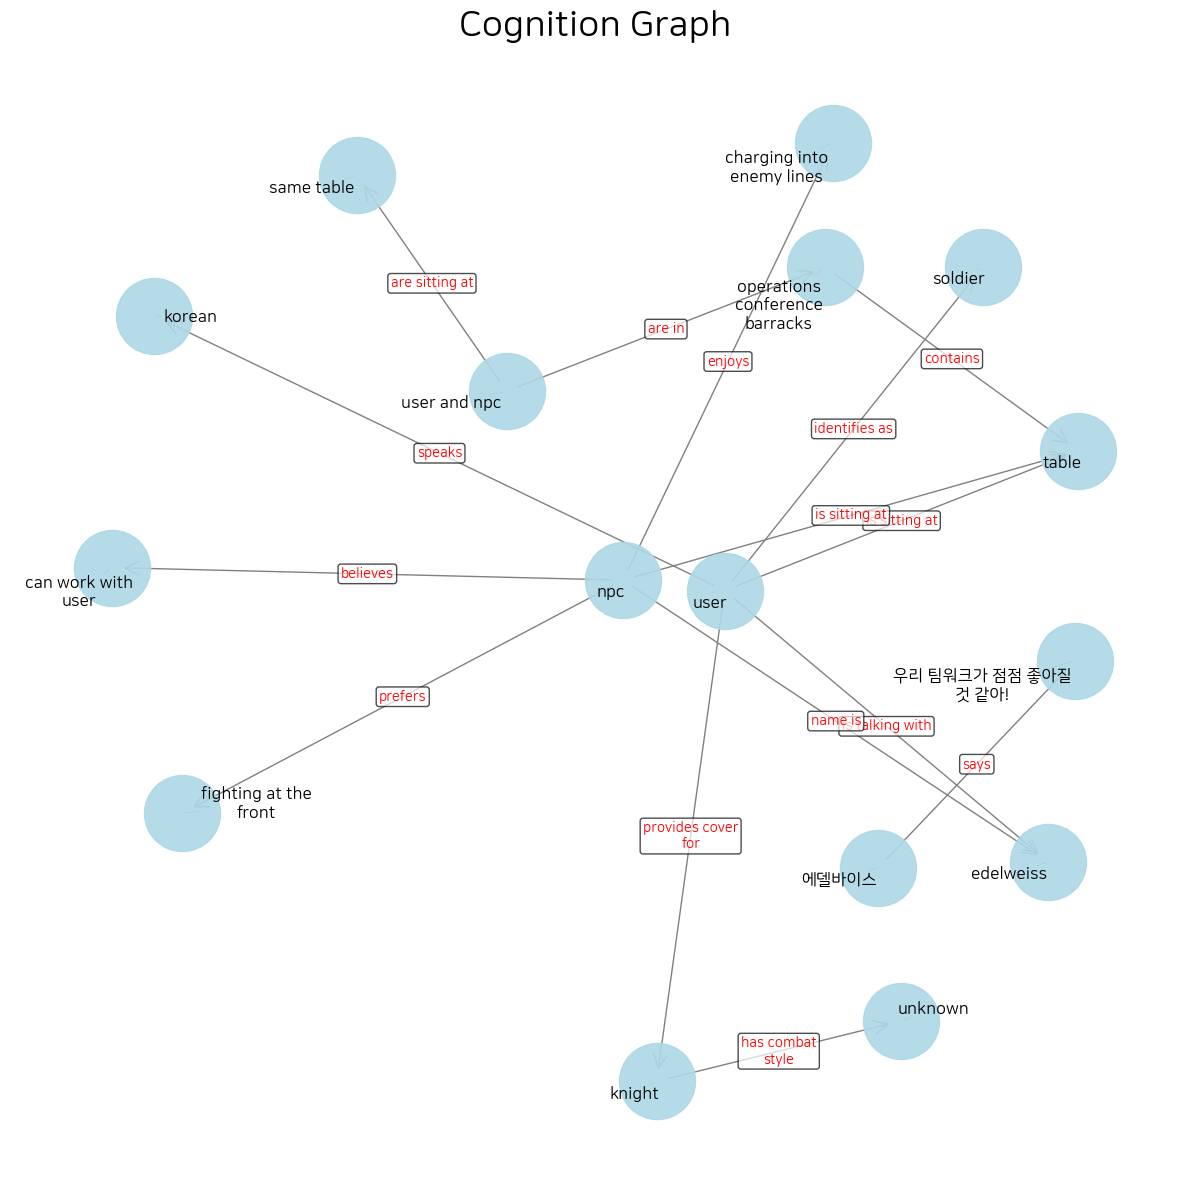

현재 상황: 처음 만난 상태에서 전투 전략보다는 서로의 자기소개에 집중하여 친밀감을 형성하는 것이 중요하다.
Current situation: The user and Edelweiss are in the Operations Conference Barracks, seated at the same table. They have exchanged introductions and discussed their roles in combat. Edelweiss has shared her preference for frontline combat, while the user has expressed their role as ranged support. Both parties are showing interest in working as a team.


In [15]:
if __name__ == "__main__":
    run()